In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import multilabel_confusion_matrix

# Myutils
from modules.get_data_function import get_dataset

In [29]:
# =========== Declare Variable ==============
STRATEGY = tf.distribute.get_strategy()    
BATCH_SIZE = 16
IMG_SIZE = 224
SEED = 42
input_path = "dataset/ChestXray NIH"

# =========================== Functions =====================================
def main():
    test_filenames = tf.io.gfile.glob(f'{input_path}/data/224x224/test/*.tfrec')
    test_dataset = get_dataset(test_filenames, color=True)
    
    tf.keras.backend.clear_session()
    model = tf.keras.models.load_model(f"/home/jovyan/ChestXray-14/results/models/Resnet50_RGB_epochs-20.h5")
    preds = model.predict(test_dataset)
    
    return test_dataset, preds


# ============ Run Main Program =============
if tf.test.gpu_device_name():
    test_dataset, preds = main()
else:
    print("\n===== Please, install GPU =====")
# ===========================================

2022-08-19 01:53:51.528657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 8009 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:17:00.0, compute capability: 8.0


Tensor("args_1:0", shape=(15,), dtype=int64)
<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 15)), types: (tf.float32, tf.int64)>


In [24]:
# def get_label_from_test_dataset(dataset):
#     tmp = []
#     for data in dataset:
#         labels = data[1]
#         for label in labels:
#             tmp.append(label.numpy())
#     return tmp

In [30]:

def get_label_from_test_dataset(dataset):
    for data in dataset:
        labels = data[1]
        for label in labels:
            yield label.numpy().tolist()
            
test_dataset_all = get_label_from_test_dataset(test_dataset)

y_true = np.array(list(test_dataset_all))
y_true[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [31]:
y_preds = (preds > 0.5).astype("int8")
y_preds

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [32]:
y_true

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
# import pickle

# with open("/home/jovyan/ChestXray-14/y_true.pk", "wb") as file:
#     pickle.dump(y_true, file)

# tmp_ = pickle.load(open("/home/jovyan/ChestXray-14/y_true.pk", "rb"))
# print(tmp_)

In [ ]:
# def my_confusion_metrics:
#     pass

# def my_multi_label_cunfusion_metrics(y_trues, y_preds):
#     tmp = tf.zeros(shape=(15,15),
#                    dtype="int32")
#     for y_true, y_pred, _index in zip(y_trues, y_preds, range(2)):
#         tmp = tmp + tf.math.confusion_matrix(y_true, y_pred, num_classes=15)
#         # break
#     return tmp


# confusion_metrics = my_multi_label_cunfusion_metrics(y_true, y_preds)

In [21]:
y_true.shape

(11200, 15)

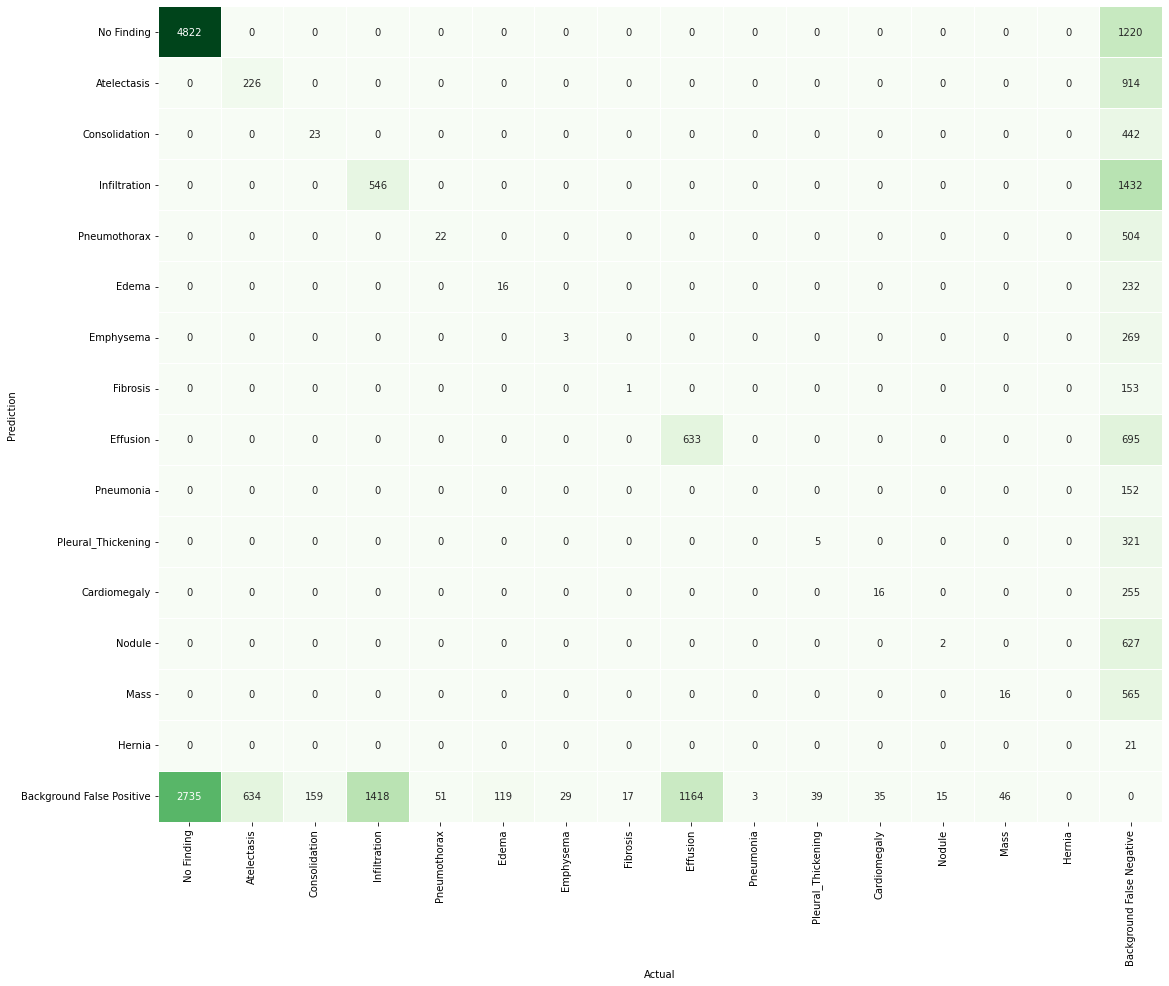

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

class ConfusionMetrics:
    def __init__(self):
        self.col_names = ['No Finding', 'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
        self.counts = 0
    
    def fit(self, y_trues, y_preds):
        confusion_metrics = np.zeros(shape=(y_trues.shape[-1]+1, 
                                            y_preds.shape[-1]+1))
        for y_true, y_pred in zip(y_trues, y_preds):
            # print("==== Round {} ====".format(self.counts))
            # print("Actual :", y_true)
            # print("Predict:", y_pred)
            for (idx, (element_true, element_pred)) in enumerate(zip(y_true, y_pred)):
                # True Positive
                if element_true == element_pred and element_true == 1: 
                    confusion_metrics[idx, idx] = confusion_metrics[idx, idx] + 1
                
                # False Negative
                elif element_true != element_pred and element_true == 1: 
                    col_idx = 15
                    confusion_metrics[idx, col_idx] = confusion_metrics[idx, col_idx] + 1
                    
                # False Positive
                elif element_true != element_pred and element_true == 0:
                    row_idx = 15
                    confusion_metrics[row_idx, idx] = confusion_metrics[row_idx, idx] + 1
            
            # if self.counts == 5:
            #     break
                
            self.counts = self.counts + 1
        return confusion_metrics, self.col_names

confusion_metrics, col_names = ConfusionMetrics().fit(y_true, y_preds)
plt.figure(figsize=(18, 15))
confusion_metrics_plot =  sns.heatmap(confusion_metrics,
                                      cmap="Greens",
                                      annot=True,
                                      label=True,
                                      fmt=".10g",
                                      cbar=False,
                                      linewidths=.5,
                                      xticklabels=col_names + ["Background False Negative"],
                                      yticklabels=col_names + ["Background False Positive"])
plt.ylabel("Prediction")
plt.xlabel("Actual")
fig = confusion_metrics_plot.get_figure()
fig.savefig("Multi_Label_Confusion_Metrics_Resnet50_RGB.png") 
plt.show();

# --- Break ---

In [ ]:
""" Columns Names for ChestXray NIH
col_names = ['No Finding', 'Atelectasis', 'Consolidation', 'Infiltration',
   'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion',
   'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass',
   'Hernia']
""";
